<a href="https://colab.research.google.com/github/CGuzman99/Data-analysis-and-machine-learning/blob/main/Information-Retrieval-System/ArXiv_IRS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Summary

Information Retrieval System of a subset of physics articles from the arXiv dataset (https://www.kaggle.com/datasets/Cornell-University/arxiv). The system implements documents preprocessing, clustering based on the similarity between documents and query handling.

#Introduction

Information retrieval (IR) is the science of searching for information in a document, searching for documents themselves, and also searching for the metadata that describes data, and for databases of texts, images or sounds. An IR system  is a sowftware system that provides acces to books, journals and other documents; it also stores and manages those documents. One of their applications are web search engines.

For nearly 30 years, ArXiv has served the public and research communities by providing open access to scholarly articles, from the vast branches of physics to the many subdisciplines of computer science to everything in between, including math, statistics, electrical engineering, quantitative biology, and economics. The arXiv dataset is a repository of 1.7 million articles, with relevant features such as artcle titles, authors, categories, abstracts, full text PDFs and more.

The goal of this project is to develop a information retrieval system of a subset of physics articles from the arXiv dataset.

#Methodology

The IR system will work on the abstract of the articles, this means when a query is made the system will look for the abstract of the articles that match the query. Due to computational power needed during preprocessing, the system works with a subset of the full dataset and I am just using physics articles, which I already set apart in a json file (https://drive.google.com/file/d/1wIhXlS-oGgOjYFQwrXZFZssly3sQqIAz/view?usp=sharing).

To build an information retrieval system there are certain steps that have to be followed (the documents will be the abstract of the articles):

1.   **Document preprocessing:** here the documents will be passed through a process of tokenization, stopwords removal and stemming. Each word of a document will represent a token, but we are only taking into account the ones that provide the text with relevant information and will not consider the rest (the stop words). To reduce the number of tokens, the words with the same base or root will be considered as the same token, and to achieve this they have to be passed through a stemming process.
2.   **Posting list creation:** a posting list for each token will be created, i.e., a list of all the documents where a token can be found one or more times.
3. **Document weighting:** a weight is assigned to each document based on the term frquencies, document frequencies and inverse document frequencies functions. The result is a matrix where each vector represent the weights of a document.
4. **Similarity:** a matrix containing a value that measures the similarity of each pair of documents using the document weights.
5. **Clustering:** the documents are divided in sets or clusters. A center for the cluster is chosen and then every document with similarity to the center greater than certain value is added to the set.
6. **Query handling:** the string or strings in a query are preprocessed (tokenization, stopwords removal and stemming) and then we can look for ocurrences in the documents using the posting lists.

For tokenization I'm using Tokenizer from the Keras library. The stopwords list and the stemming algorithm (SnowballStemmer) are taken from the nltk library. For plotting and data visualization in the results section I'm using matplotlib.




In [ ]:
from google.colab import drive,files
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import math
import statistics
import random
import nltk
nltk.download('stopwords')
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import json


drive.mount("/content/gdrive")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/gdrive


## Functions

In this section you can find all the functions defined to build the system.

In [ ]:
#Returns a list of categories
def getCategories(item_cat, categories):
  lst_cat = []
  keys = categories.keys()
  for cat in keys:
    if cat in item_cat:
      lst_cat.append(categories[cat])
  return lst_cat

#Prints the information of an article
def print_info(index, itemdata, categories):
  item = itemdata[index]
  cat = getCategories(item["categories"], categories)
  print('Title:', item["title"])
  print('Authors:', item["authors"])
  print('Categories:', ", ".join(cat))
  print('Doi:', item["doi"])
  print(item["abstract"])

#Prints the information of a list of articles
def print_info_lst(index_lst, itemdata, categories):
  for index in index_lst:
    print('----------------------------------------------')
    print_info(index, itemdata, categories)

In [ ]:
#Intersection of two lists
def intersection(lst1, lst2):
  lst = [val for val in lst1 if val in lst2]
  return lst

#Union of two lists
def union(lst1, lst2):
  s1 = set(lst1)
  s2 = set(lst2)
  lst = list(s1.union(s2))
  lst.sort()
  return lst

#Transpose matrix
def traspuesta(matriz):
  tr = []
  for i in range(len(matriz[0])):
    x = [y[i] for y in matriz]
    tr.append(x)
  return tr

def sortDic(dic, rev=False):
  new_dic = {}
  keys = sorted(dic.keys(), reverse=rev)
  for key in keys:
    new_dic[key] = dic[key]
  return new_dic

def sortDicValues(dic, rev=False):
  new_dic = {}
  values = list(dic.items())
  values.sort(key=keySortItem, reverse=rev)
  for l,val in values:
    new_dic[l] = val
  return new_dic

def keySortItem(itm):
  return itm[1]

def graph(x, y, xlab, ylab, n):
  plt.subplot(2,1,n)
  plt.plot(x, y)
  plt.xlabel(xlab)
  plt.ylabel(ylab)
  plt.show

#F measure with beta=1 (or alfa=1/2) as default
def F_measure(rec_prec, beta=1):
  F = {}
  b = pow(beta,2)
  for p,r in rec_prec.items():
    r = 0.5
    f = ((b+1)*p*r)/(b*p+r)
    F[p*100] = f*100
  sortDic(F)
  return F

def stdIndex(similarity):
  std = []
  for vector in similarity:
    std.append(statistics.pstdev(vector))
  aux = sorted(std, reverse=True)
  index = []
  for val in aux:
    ind = std.index(val)
    std.pop(ind)
    index.append(ind)
  return index, aux

def graphDistribution(similarity, doc):
  plt.hist(similarity[doc], bins=20, label='Document index: ' + str(doc))
  plt.legend()
  plt.plot()


### Tokenization, posting list

In [ ]:
def remove_d(lst):
  data = []
  for string in lst:
    string = string.replace('Ñ', 'N')
    string = string.replace('Ü', 'U')
    data.append(''.join([s for s in string if not s.isdigit()]))
  return data

def tokenize(data):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(data)
  sw = set(stopwords.words('english'))
  tokens = list(tokenizer.word_index.keys())
  aux = []
  for token in tokens:
    if not token in sw:
      aux.append(token)
  aux.sort()
  tokens_rel = stemming(aux)
  tokens_index = tokenIndex(tokens_rel)
  return tokens_rel, tokens_index

def stemming(tokens):
  stemmer = SnowballStemmer('english')
  tokens_rel = {}
  for token in tokens:
    word_st = stemmer.stem(token)
    if not word_st in tokens_rel.keys():
      tokens_rel[word_st] = []
    tokens_rel[word_st].append(token)
  return tokens_rel

def tokenIndex(tokens):
  ti = {}
  i = 0
  for token in tokens:
    ti[token] = i
    i += 1
  return ti

#Create posting list
def crearPL(tokens_rel, text):
  pl = []
  for token, words in tokens_rel.items():
    aux = []
    for word in words:
      for i in range(len(text)):
        if (word in text[i].lower()) and not (i in aux):
          aux.append(i)
    pl.append(aux)
  return pl

#Intersection between the posting list and the query words
def intersectionPL(words, pl, ti):
  word = ''
  while not (word in ti.keys()) and len(words)>0:
    word = words.pop(0)
  if not word in ti.keys():
    return []
  i = ti.get(word)
  lst = pl[i]
  for word in words:
    if word in ti.keys():
      i = ti[word]
      lst = intersection(lst, pl[i])
  return lst


###Query

In [ ]:
#Query of a string
def query(query, pl, ti):
  string = query.upper()
  string = remove_d([string])
  q_tkr, q_tki = tokenize(string)
  words = list(q_tkr.keys())
  doc = intersectionPL(words, pl, ti)
  return doc,q_tkr

#Query of a list of strings: query=[string,...]
def query_lst(qr, pl, ti):
  doc = []
  q_tkr = {}
  for string in qr:
    lst,tkr = query(string, pl, ti)
    doc = union(doc, lst)
    for token in tkr:
      if not token in q_tkr.keys():
        q_tkr[token] = tkr[token]
        continue
      q_tkr[token] = union(q_tkr[token], tkr[token])
  return doc, q_tkr

#Query weighting
def queryWeighting(t_rel, q_tokens, query):
  string = ''
  if isinstance(query, str):
    string = query
  else:
    for cad in query:
      string = string + ' ' + cad
  q_tf = []
  q_idf = []
  q_weighting = []

  l = len(t_rel.keys())
  #tf, idf, tf-idf
  for i in range(l):
    q_tf.append(0)
    q_idf.append(0)
    token = list(t_rel.keys())[i]
    if token in q_tokens.keys():
      q_idf[i] = math.log(350,10)
      for word in q_tokens[token]:
        q_tf[i] += string.count(word)
    val = q_tf[i]*q_idf[i]
    q_weighting.append(val)
  return q_weighting

### Document weighting

In [ ]:
#Term frequency
def termFrequency(data, tr):
  tf = []
  for term in tr:
    aux = []
    for i in range(len(data)):
      freq = 0
      row = data[i].lower()
      for word in tr[term]:
        freq += row.count(word)
      aux.append(freq)
    tf.append(aux)
  return tf

#Document frequency
def documentFreq(tf):
  df = []
  for vector in tf:
    freq = 0
    for f in vector:
      if (f>0):
        freq += 1
    df.append(freq)
  return df

#Inverse document frquency
def idf(df, n, log_base=math.e):
  idf = []
  x = 1
  for val in df:
    x = 1
    if val>0:
      x = n/val
    res = math.log(x, log_base)
    idf.append(res)
  return idf

#Tf-idf weighting
def tf_idfWeighting(tf, idf):
  tf_idf = []
  for j in range(len(tf)):
    aux = []
    for i in range(len(tf[j])):
      aux.append(tf[j][i]*idf[j])
    tf_idf.append(aux)
  return tf_idf

def docWeighting(l1,tokens_rel):
  tf = termFrequency(l1,tokens_rel)
  df = documentFreq(tf)
  _idf = idf(df, len(l1), log_base=10)
  tf_idf = tf_idfWeighting(tf, _idf)
  dc_weight = traspuesta(tf_idf)
  return dc_weight

###Compressing

In [ ]:
def freqLetras(tokens):
  letras_fr = {}
  for i in range(97, 123):
    n = 0
    for token in tokens:
      n += token.count(chr(i))
    letras_fr[chr(i)] = n
  letras_fr = sortDicValues(letras_fr, rev=True)
  return letras_fr

#Code for compressing
def compressCode(letras):
  code = {}
  cad = '0'
  for l in letras:
    cad += '1'
    code[l] = cad
  return code

#Compress
def compress(tokens):
  letras_fr = freqLetras(tokens)
  letras = compressCode(letras_fr)
  cmp_string = ''
  for word in tokens:
    cmp_string += str(len(word))
    for w in word:
      if w in letras.keys():
        cmp_string += letras[w]
  return cmp_string

### Similarity

In [ ]:
#Documents similarity
def similitud_doc(matriz):
  sim = []
  for v1 in matriz:
    v = []
    for v2 in matriz:
      val = similarity(v1, v2)
      v.append(val)
    sim.append(v)
  return sim

def similarity(v1, v2):
  dp = dot(v1,v2)
  n1 = norma(v1)
  n2 = norma(v2)
  sml = dp/(n1*n2)
  return sml

#Dot product between two vectors
def dot(v1, v2):
  dp = 0
  for i in range(len(v1)):
    dp += (v1[i]*v2[i])
  return dp

#Norm of a vector
def norma(vect):
  suma = 0
  for x in vect:
    suma += (x**2)
  return math.sqrt(suma)

#Order by similarity
def simSort(rtr, qw, mtr):
  dct = {}
  for i in rtr:
    vector = mtr[i]
    sim = similarity(qw, vector)
    dct[sim] = i
  dct = sortDic(dct, rev=True)
  return list(dct.values())

### Clustering

In [ ]:
#Create clusters using standard deviation
def clusteringSTD(simM, s):
  ctr = []
  clusters = []
  length = len(simM)
  std_index, std = stdIndex(simM)
  while len(std_index)>0:
    ind = std_index.pop(0)
    if inClusters(ind, clusters):
      continue
    clusters.append(createClusterS(ind, simM, s))
    ctr.append(ind)
  return clusters, ctr

#Create clusters
def clustering(smlM, s):
  ctr = []
  clusters = []
  length = len(smlM)
  for i in range(length):
    if not inClusters(i, clusters):
      clusters.append(createClusterS(i, smlM, s))
      ctr.append(i)
  return clusters, ctr

#Create cluster with n elements
def createClusterN(doc, dw, n):
  dic_sim = {}
  v_sim = dw[doc]
  for i in range(len(v_sim)):
    key = v_sim[i]
    dic_sim[key] = i
  dic_sim = sortDic(dic_sim, rev=True)
  cluster = [doc]
  values = list(dic_sim.values())
  for i in range(n-1):
    cluster.append(values[i])
  return cluster

#Create clustes with documents with similarity greater than or equal to s
def createClusterS(doc, sml, s):
  dic_sim = {}
  v_sim = sml[doc]
  for i in range(len(v_sim)):
    dic_sim[i] = v_sim[i]
  cluster = [doc]
  for i,val in dic_sim.items():
    if val>=s:
      cluster.append(i)
  return cluster

#Returns true if doc is in a cluster, and false otherwise
def inClusters(doc, clusters):
  for cluster in clusters:
    if doc in cluster:
      return True
  return False

#Returns de index of the cluster with it's main element as the most similar to doc
def getSimCluster(sml, ctr, doc):
  s = 0
  ind = 0
  for i in range(len(ctr)):
    c = ctr[i]
    if sml[doc][c]>s:
      s = sml[doc][c]
      ind = i
  return ind

#Returns a list of clusters most similar to the documents in docs
def getClusters(sml, ctr, docs):
  ind = []
  for doc in docs:
    i = getSimCluster(sml, ctr, doc)
    if i not in ind:
      ind.append(i)
  ind.sort()
  return ind

## Main code

In this section the data is downloaded and the system is built. The documents in a cluster are elements with relative similarity to the center document of the cluster greater than 0.15.

In [ ]:
itemdata = []
json_file = open('/content/gdrive/My Drive/arxiv-physics.json', 'r')
lines = json_file.readlines()
for line in lines:
  itemdata.append(json.loads(line))

In [ ]:
ids = []
abstract = []
for item in itemdata:
  ids.append(item["id"])
  abstr = item["abstract"]
  abstract.append(abstr.upper())

In [ ]:
categories = {
    'Physics' : ['astro-ph', 'cond-mat', 'gr-qc', 'hep-ex', 'hep-lat', 'hep-ph', 'hep-th', 'math-ph', 'nlin', 'nucl-ex', 'nucl-th', 'physics', 'quant-ph'],
    'Mathemathics' : ['math'],
    'Computer Science' : ['CoRR'],
    'Quantitative Biology' : ['q-bio'],
    'Quantitative Finance' : ['q-fin'],
    'Statistics' : ['stat'],
    'Electrical Engineering and Systems Science' : ['eess'],
    'Economics' : ['econ']
}
physics_subc = {
    'astro-ph' : 'Astrophysics',
    'cond-mat' : 'Condensed Matter',
    'gr-qc' : 'General Relativity and Quantum Cosmology',
    'hep-ex' : 'High Energy Physics - Experiment',
    'hep-lat' : 'High Energy Physcics - Lattice',
    'hep-ph' : 'High Energy Physics - Phenomenology',
    'hep-th' : 'High Energy Physics - Theory',
    'math-ph' : 'Mathematical Physics',
    'nlin' : 'Nonlinear Sciences',
    'nucl-ex' : 'Nuclear Experiment',
    'nucl-th' : 'Nuclear Theory',
    'physics' : 'Physics',
    'quant-ph' : 'Quantum Physics'
}


In [ ]:
#Documents preprocessing
abstract2 = remove_d(abstract[:1000])
tokens_rel, tokens_index = tokenize(abstract2)
posting_list = crearPL(tokens_rel, abstract2)
tokens_cmp = compress(tokens_rel)

In [ ]:
#Documents preprocessing
doc_weights = docWeighting(abstract2, tokens_rel)
sml = similitud_doc(doc_weights)

In [ ]:
#Creates clusters
clusters,ctr = clustering(sml, 0.15)
#Creates clusters using standard deviation
clusters_std,ctr_std = clusteringSTD(sml, 0.15)

#Results

With 1000 documents, a total of 180 clusters were created, each one having between 2 and 74 elements. The average size of the clusters is 11.

In [ ]:
#Number of clusters
print(len(clusters_std))

180


Average size:  11.411111111111111
Max size:  74
Min size:  2


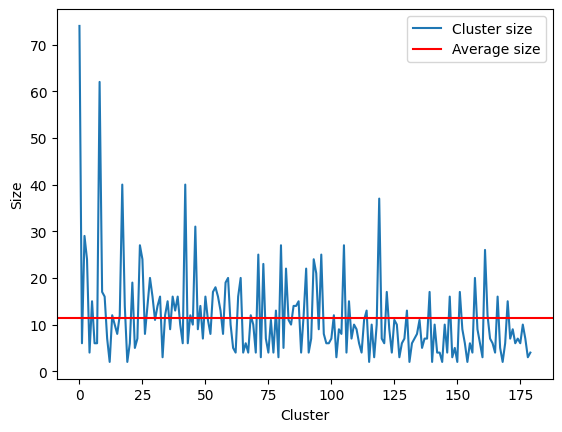

In [ ]:
#Size of each cluster
import numpy as np

clusters_size = []
for cluster in clusters_std:
  clusters_size.append(len(cluster))

avg_size = np.mean(clusters_size)
print('Average size: ', avg_size)
print('Max size: ', np.max(clusters_size))
print('Min size: ', np.min(clusters_size))

plt.plot(clusters_size, label='Cluster size')
plt.axhline(avg_size, color='r', label='Average size')
plt.xlabel('Cluster')
plt.ylabel('Size')
plt.legend()
plt.show()

Here is a distribution of the similarity of the documents relative to the document x that is the center of the first cluster. We can see that most of the documents (almost 700 documents) have a similarity less than 0.05, and just a few of them have similarity greater than 0.15 (which is the value I chose to make the clusters).

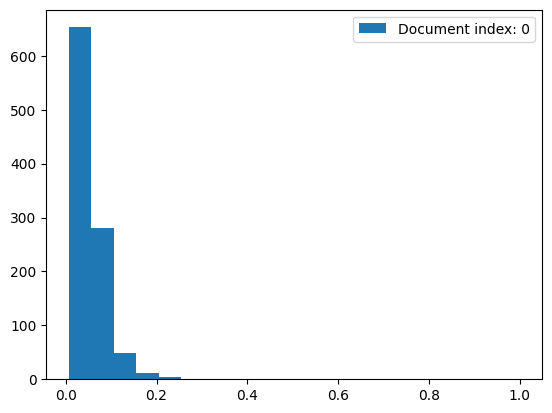

In [ ]:
#Distribution from document with index x
x = ctr[0]
graphDistribution(sml, x)

Now a query is done, searching for the word 'cosmology' in the documents (or a word with the same base). As a result, a list with 50 documents is retrieved. I'm printing the first 5 elements of this list.

In [ ]:
#Query example
retrieved, q_tkr = query('cosmology', posting_list, tokens_index)

In [ ]:
print('Number of retrieved documents: ', len(retrieved))
#Prints information of the results from de query
print_info_lst(retrieved[:5], itemdata, physics_subc)

Number of retrieved documents:  50
----------------------------------------------
Title: Polymer Quantum Mechanics and its Continuum Limit
Authors: Alejandro Corichi, Tatjana Vukasinac and Jose A. Zapata
Categories: General Relativity and Quantum Cosmology
Doi: 10.1103/PhysRevD.76.044016
  A rather non-standard quantum representation of the canonical commutation
relations of quantum mechanics systems, known as the polymer representation has
gained some attention in recent years, due to its possible relation with Planck
scale physics. In particular, this approach has been followed in a symmetric
sector of loop quantum gravity known as loop quantum cosmology. Here we explore
different aspects of the relation between the ordinary Schroedinger theory and
the polymer description. The paper has two parts. In the first one, we derive
the polymer quantum mechanics starting from the ordinary Schroedinger theory
and show that the polymer description arises as an appropriate limit. In the
second 

From the query we got documents from 6 different categories, where the most repeated one is Astrophysics and the two categories with less amount of documents are Physics and Quantum Physics.

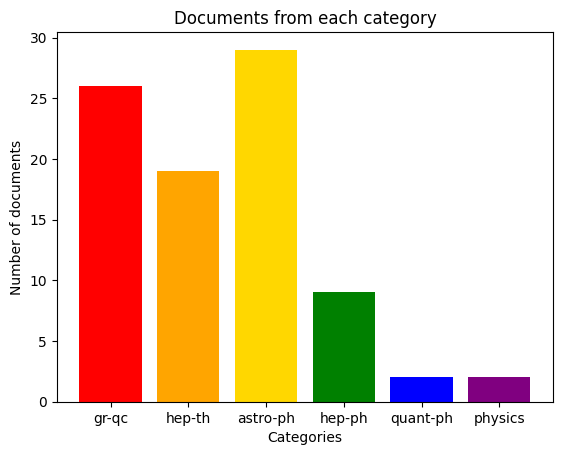

In [ ]:
cat_count = {}
for doc in retrieved:
  item_categories = itemdata[doc]['categories']
  #print(item_categories)
  for cat in physics_subc.keys():
    if cat in item_categories:
      if cat in cat_count.keys():
        cat_count[cat] += 1
      else:
        cat_count[cat] = 1

bar_colors = ['red', 'orange', 'gold', 'green', 'blue', 'purple']

plt.clf()

plt.bar(cat_count.keys(), cat_count.values(), color=bar_colors)
plt.xlabel('Categories')
plt.ylabel('Number of documents')
plt.title('Documents from each category')
plt.show()

#Conclusions

An information retrieval system is succesfully implemented for the physics articles from the arXiv dataset. The similarity based clustering is a good approach for the documents unsupervised classification. For 1000 documents a total of 180 clusters are formed with and average size of 11 documents per cluster. Finally, a succesful query was realized, retrieving 50 documents with the searched word or a word with the same root appearing at least once in the abstract of the article.

This a relatively simple system and more complex techniques can be implemented to improve it's performance. But this naive approach is able to solve the problem for simple systems.